# KNN Optimum dengan GridSearch - Stress Level Detection

Implementasi KNN dengan optimasi hyperparameter menggunakan GridSearchCV untuk klasifikasi tingkat stress.

In [1]:
!pip install --upgrade imbalanced-learn
!pip install --upgrade scikit-learn
!pip install pandas
!pip install matplotlib
!pip install seaborn

  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl (11.2 MB)
  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl (11.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.1
    Uninstalling scikit-learn-1.7.1:
      Successfully uninstalled scikit-learn-1.7.1
    Uninstalling scikit-learn-1.7.1:
      Successfully uninstalled scikit-learn-1.7.1
  Using cached scikit_learn-1.7.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached scikit_learn-1.7.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.1-cp312-cp312-macosx_12_0_arm64.whl (8.6 MB)
Using cached scikit_learn-1.7.1-cp312-cp312-macosx_12_0_arm64.whl (8.6 MB)
  Atte

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

print("✅ Library berhasil diimport")

✅ Library berhasil diimport


## 1. Data Loading dan Preprocessing

In [ ]:
FILE_PATH = './dataset/fix dataset 1031.csv'

# Read CSV with semicolon as separator and handle mixed decimal separators
df = pd.read_csv(FILE_PATH, sep=';', decimal='.')
dataset = df.copy()

# Tampilkan Semua row pada kolom pertama yang memiliki nilai NaN
print("📊 DATASET INFORMATION:")
print("Jumlah baris yang memiliki nilai NaN pada kolom pertama:", dataset[dataset.columns[0]].isna().sum())

# Bersihkan data dengan menghapus baris yang memiliki nilai NaN pada kolom pertama
dataset = dataset.dropna(subset=[dataset.columns[0]])

print("Dataset shape:", dataset.shape)
display(dataset.head())

Dataset shape: (1096, 13)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1.0,Male,27.0,Software Engineer,06.01,6.0,42.0,6.0,Overweight,126/83,77.0,4200.0,NaN
1,2.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,NaN
2,3.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,NaN
3,4.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea
4,5.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea


In [4]:
# Fill missing values in Sleep Disorder with 'Normal'
dataset['Sleep Disorder'] = dataset['Sleep Disorder'].fillna('Normal')

# Split Blood Pressure column
if 'Blood Pressure' in dataset.columns:
    dataset[['Systolic', 'Diastolic']] = dataset['Blood Pressure'].str.split('/', expand=True)
    dataset['Systolic'] = pd.to_numeric(dataset['Systolic'], errors='coerce')
    dataset['Diastolic'] = pd.to_numeric(dataset['Diastolic'], errors='coerce')
    dataset = dataset.drop('Blood Pressure', axis=1)

# Clean numeric columns
kolom_numerik = ["Sleep Duration", "Heart Rate", "Daily Steps", "Systolic", "Diastolic"]
for col in kolom_numerik:
    if col in dataset.columns:
        dataset[col] = dataset[col].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

print("✅ Data preprocessing selesai")

✅ Data preprocessing selesai


## 2. Target Encoding dan Feature Selection

In [5]:
# Label encoding for target
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(dataset['Sleep Disorder'])

print("Target classes:", label_encoder.classes_)
print("Encoded values:", np.unique(target_encoded))

# Show class distribution
print("\n=== DISTRIBUSI KELAS ====")
class_counts = pd.Series(target_encoded).value_counts().sort_index()
for i, count in enumerate(class_counts):
    print(f"{label_encoder.classes_[i]}: {count} samples")

Target classes: ['Insomnia' 'Normal' 'Sleep Apnea']
Encoded values: [0 1 2]

=== DISTRIBUSI KELAS ====
Insomnia: 296 samples
Normal: 503 samples
Sleep Apnea: 297 samples


In [6]:
# Select features
feature_columns = ["Gender", "Age", "Occupation", "Sleep Duration", "Quality of Sleep", 
                  "Physical Activity Level", "Stress Level", "BMI Category", "Systolic", "Diastolic"]

# Filter only existing columns
available_features = [col for col in feature_columns if col in dataset.columns]
features = dataset[available_features]

print("Selected features:", available_features)
print("Features shape:", features.shape)

Selected features: ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Systolic', 'Diastolic']
Features shape: (1096, 10)


## 3. Data Splitting

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target_encoded, test_size=0.2, random_state=42, stratify=target_encoded
)

print("=== DATA SPLIT ====")
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

print("\nDistribusi y_train:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for i, count in enumerate(train_dist):
    print(f"{label_encoder.classes_[i]}: {count} samples")

=== DATA SPLIT ====
Training set: 876 samples
Test set: 220 samples

Distribusi y_train:
Insomnia: 237 samples
Normal: 402 samples
Sleep Apnea: 237 samples


## 4. Pipeline Setup

In [8]:
# Define numerical and categorical features
numerical_features = [col for col in available_features if features[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in available_features if features[col].dtype == 'object']

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# Create preprocessors
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

print("✅ Preprocessor pipeline created")

Numerical features: ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Systolic', 'Diastolic']
Categorical features: ['Gender', 'Occupation', 'BMI Category']
✅ Preprocessor pipeline created


## 5. Baseline Model (Before GridSearch)

In [9]:
# Create baseline KNN pipeline (default parameters)
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

# Train baseline model
print("Training baseline model...")
baseline_pipeline.fit(X_train, y_train)
baseline_pred = baseline_pipeline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_pred)

print("=== BASELINE MODEL (BEFORE GridSearch) ====")
print("Default hyperparameters:")
knn_params = baseline_pipeline.named_steps['knn'].get_params()
important_params = ['n_neighbors', 'weights', 'algorithm', 'metric', 'p']
for param in important_params:
    if param in knn_params:
        print(f"  {param}: {knn_params[param]}")

print(f"\nBaseline accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")

Training baseline model...
=== BASELINE MODEL (BEFORE GridSearch) ====
Default hyperparameters:
  n_neighbors: 5
  weights: uniform
  algorithm: auto
  metric: minkowski
  p: 2

Baseline accuracy: 0.9227 (92.27%)


## 6. GridSearchCV untuk Optimasi Hyperparameter

In [10]:
# Define parameter grid for GridSearch
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': [1, 2]  # Only relevant for minkowski metric
}

print("Parameter grid for GridSearch:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations to test: {np.prod([len(v) for v in param_grid.values()])}")

Parameter grid for GridSearch:
  knn__n_neighbors: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
  knn__weights: ['uniform', 'distance']
  knn__algorithm: ['auto', 'ball_tree', 'kd_tree', 'brute']
  knn__metric: ['euclidean', 'manhattan', 'minkowski']
  knn__p: [1, 2]

Total combinations to test: 480


In [11]:
# Create pipeline for GridSearch
grid_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

# Perform GridSearchCV
print("Starting GridSearchCV...")
print("This may take several minutes...")

start_time = time.time()

grid_search = GridSearchCV(
    grid_pipeline,
    param_grid,
    cv=5,  # 5-fold cross validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n✅ GridSearchCV completed in {elapsed_time:.2f} seconds")

Starting GridSearchCV...
This may take several minutes...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Fitting 5 folds for each of 480 candidates, totalling 2400 fits

✅ GridSearchCV completed in 7.86 seconds

✅ GridSearchCV completed in 7.86 seconds


## 7. GridSearch Results

In [12]:
# Display GridSearch results
print("=== GRIDSEARCH RESULTS ====")
print("\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")

# Test the best model
best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(X_test)
grid_accuracy = accuracy_score(y_test, y_pred_grid)

print(f"Test set accuracy with best model: {grid_accuracy:.4f} ({grid_accuracy*100:.2f}%)")

=== GRIDSEARCH RESULTS ====

Best parameters found:
  knn__algorithm: ball_tree
  knn__metric: euclidean
  knn__n_neighbors: 5
  knn__p: 1
  knn__weights: uniform

Best cross-validation score: 0.9144 (91.44%)
Test set accuracy with best model: 0.9318 (93.18%)


In [13]:
# Compare Before vs After GridSearch
print("=== COMPARISON: BEFORE vs AFTER GridSearch ====")
print("\nBEFORE GridSearch (default parameters):")
print(f"  n_neighbors: 5")
print(f"  weights: uniform")
print(f"  algorithm: auto")
print(f"  metric: minkowski")
print(f"  p: 2")
print(f"  Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")

print("\nAFTER GridSearch (optimized parameters):")
for param, value in grid_search.best_params_.items():
    param_name = param.replace('knn__', '')
    print(f"  {param_name}: {value}")
print(f"  Accuracy: {grid_accuracy:.4f} ({grid_accuracy*100:.2f}%)")

improvement = grid_accuracy - baseline_accuracy
print(f"\nImprovement: {improvement:.4f} ({improvement*100:.2f} percentage points)")

if improvement > 0:
    print("✅ GridSearch improved the model performance!")
elif improvement == 0:
    print("➖ No improvement from GridSearch")
else:
    print("⚠️ GridSearch resulted in lower performance (may indicate overfitting)")

=== COMPARISON: BEFORE vs AFTER GridSearch ====

BEFORE GridSearch (default parameters):
  n_neighbors: 5
  weights: uniform
  algorithm: auto
  metric: minkowski
  p: 2
  Accuracy: 0.9227 (92.27%)

AFTER GridSearch (optimized parameters):
  algorithm: ball_tree
  metric: euclidean
  n_neighbors: 5
  p: 1
  weights: uniform
  Accuracy: 0.9318 (93.18%)

Improvement: 0.0091 (0.91 percentage points)
✅ GridSearch improved the model performance!


## 8. Detailed Performance Analysis

In [14]:
# Detailed classification report
print("=== DETAILED PERFORMANCE ANALYSIS ====")
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_grid, target_names=label_encoder.classes_))

=== DETAILED PERFORMANCE ANALYSIS ====

Classification Report (Best Model):
              precision    recall  f1-score   support

    Insomnia       0.96      0.88      0.92        59
      Normal       0.91      0.97      0.94       101
 Sleep Apnea       0.95      0.92      0.93        60

    accuracy                           0.93       220
   macro avg       0.94      0.92      0.93       220
weighted avg       0.93      0.93      0.93       220



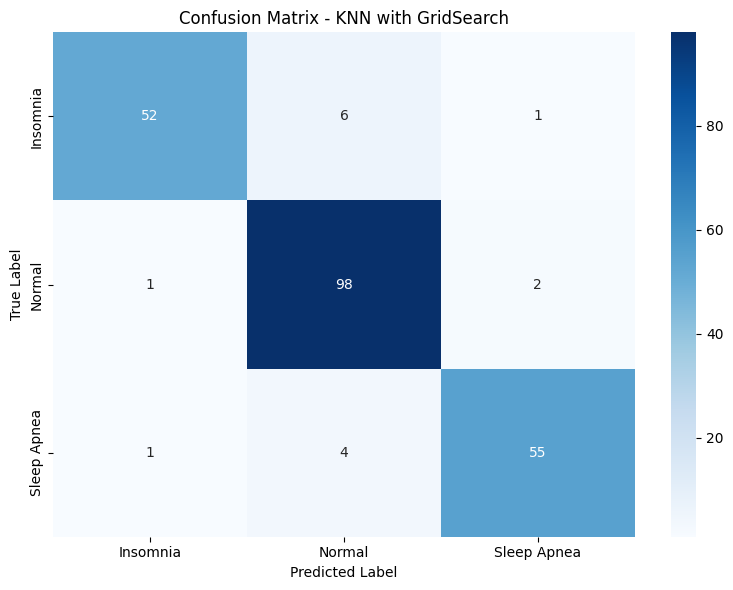

In [15]:
# Confusion Matrix
cm_grid = confusion_matrix(y_test, y_pred_grid)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_grid, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - KNN with GridSearch")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 9. Top 10 Best Parameter Combinations

In [16]:
# Display top 10 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
top_10 = results_df.nlargest(10, 'mean_test_score')[['mean_test_score', 'std_test_score', 'params']]

print("=== TOP 10 PARAMETER COMBINATIONS ====")
for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    print(f"\n{i}. Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   Parameters: {row['params']}")

=== TOP 10 PARAMETER COMBINATIONS ====

1. Score: 0.9144 (±0.0114)
   Parameters: {'knn__algorithm': 'ball_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}

2. Score: 0.9144 (±0.0114)
   Parameters: {'knn__algorithm': 'ball_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}

3. Score: 0.9144 (±0.0114)
   Parameters: {'knn__algorithm': 'ball_tree', 'knn__metric': 'minkowski', 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}

4. Score: 0.9144 (±0.0114)
   Parameters: {'knn__algorithm': 'kd_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}

5. Score: 0.9144 (±0.0114)
   Parameters: {'knn__algorithm': 'kd_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}

6. Score: 0.9144 (±0.0114)
   Parameters: {'knn__algorithm': 'kd_tree', 'knn__metric': 'minkowski', 'knn__n_neighbors': 5, 'knn__p': 2

## 10. Performance Visualization

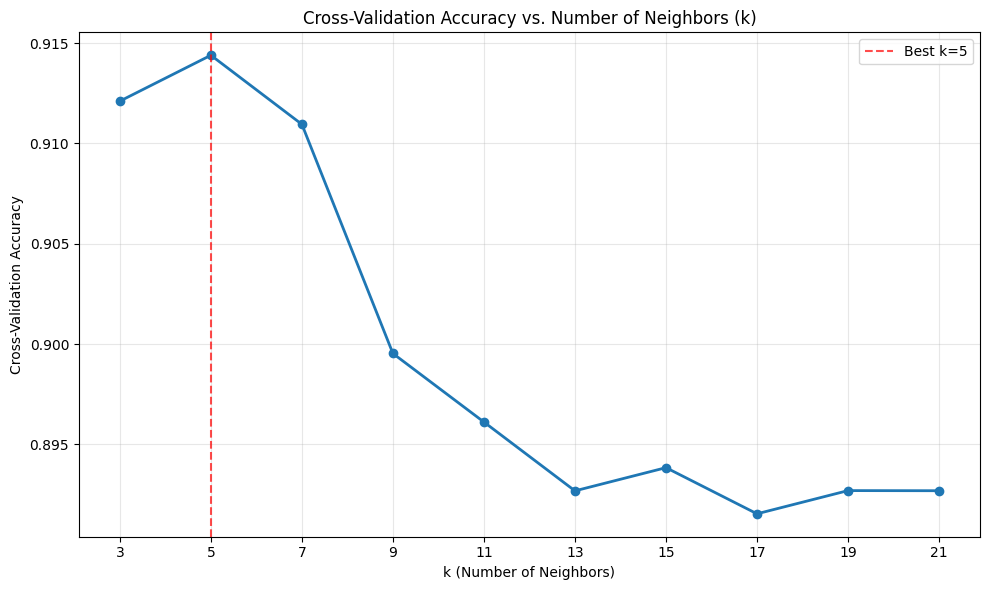

In [17]:
# Visualize the effect of n_neighbors parameter
k_values = param_grid['knn__n_neighbors']
k_scores = []

# Filter results for the best other parameters but varying k
best_params_except_k = {k: v for k, v in grid_search.best_params_.items() if k != 'knn__n_neighbors'}

for k in k_values:
    # Find results with this k and best other parameters
    matching_rows = results_df[
        (results_df['param_knn__n_neighbors'] == k) &
        (results_df['param_knn__weights'] == best_params_except_k.get('knn__weights')) &
        (results_df['param_knn__algorithm'] == best_params_except_k.get('knn__algorithm')) &
        (results_df['param_knn__metric'] == best_params_except_k.get('knn__metric')) &
        (results_df['param_knn__p'] == best_params_except_k.get('knn__p'))
    ]
    
    if not matching_rows.empty:
        k_scores.append(matching_rows['mean_test_score'].iloc[0])
    else:
        k_scores.append(0)

# Plot k vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, marker='o', linewidth=2, markersize=6)
best_k = grid_search.best_params_['knn__n_neighbors']
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
plt.title('Cross-Validation Accuracy vs. Number of Neighbors (k)')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(k_values)
plt.tight_layout()
plt.show()

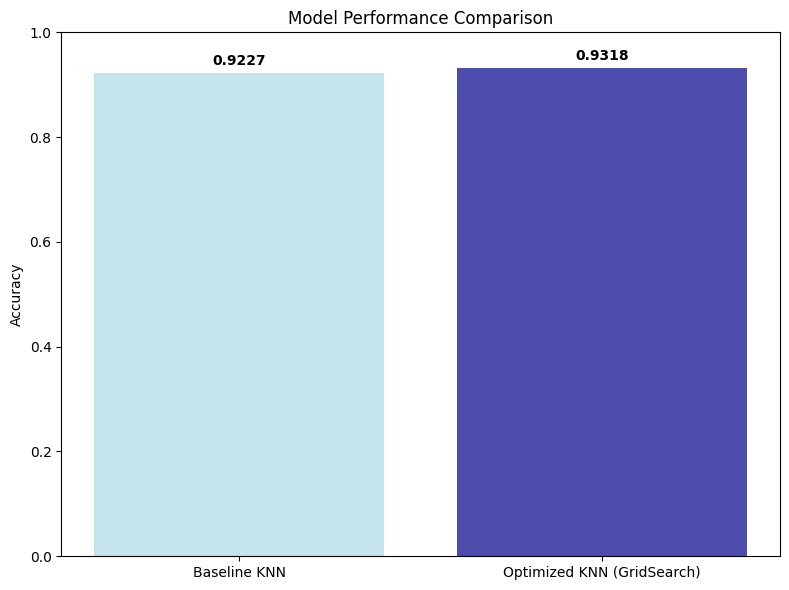

In [18]:
# Compare baseline vs optimized model performance
models = ['Baseline KNN', 'Optimized KNN (GridSearch)']
accuracies = [baseline_accuracy, grid_accuracy]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['lightblue', 'darkblue'], alpha=0.7)
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Final Summary

In [19]:
print("=" * 60)
print("FINAL SUMMARY - KNN OPTIMIZATION WITH GRIDSEARCH")
print("=" * 60)

print("\n📊 DATASET INFORMATION:")
print(f"   Total samples: {len(dataset)}")
print(f"   Features used: {len(available_features)}")
print(f"   Classes: {len(label_encoder.classes_)} ({', '.join(label_encoder.classes_)})")

print("\n🔍 GRIDSEARCH CONFIGURATION:")
print(f"   Total parameter combinations tested: {len(results_df)}")
print(f"   Cross-validation folds: 5")
print(f"   Search time: {elapsed_time:.2f} seconds")

print("\n📈 PERFORMANCE RESULTS:")
print(f"   Baseline accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"   Optimized accuracy: {grid_accuracy:.4f} ({grid_accuracy*100:.2f}%)")
print(f"   Improvement: {improvement*100:+.2f} percentage points")

print("\n⚙️ OPTIMAL HYPERPARAMETERS:")
for param, value in grid_search.best_params_.items():
    param_name = param.replace('knn__', '')
    print(f"   {param_name}: {value}")

print("\n🎯 KEY FINDINGS:")
optimal_k = grid_search.best_params_['knn__n_neighbors']
print(f"   • Optimal k value: {optimal_k}")
print(f"   • Best weights: {grid_search.best_params_['knn__weights']}")
print(f"   • Best algorithm: {grid_search.best_params_['knn__algorithm']}")
print(f"   • Best metric: {grid_search.best_params_['knn__metric']}")

if improvement > 0.01:
    print("\n✅ GridSearch significantly improved model performance!")
elif improvement > 0:
    print("\n✅ GridSearch slightly improved model performance.")
else:
    print("\n➖ GridSearch did not improve model performance.")

print("=" * 60)

FINAL SUMMARY - KNN OPTIMIZATION WITH GRIDSEARCH

📊 DATASET INFORMATION:
   Total samples: 1096
   Features used: 10
   Classes: 3 (Insomnia, Normal, Sleep Apnea)

🔍 GRIDSEARCH CONFIGURATION:
   Total parameter combinations tested: 480
   Cross-validation folds: 5
   Search time: 7.86 seconds

📈 PERFORMANCE RESULTS:
   Baseline accuracy: 0.9227 (92.27%)
   Optimized accuracy: 0.9318 (93.18%)
   Improvement: +0.91 percentage points

⚙️ OPTIMAL HYPERPARAMETERS:
   algorithm: ball_tree
   metric: euclidean
   n_neighbors: 5
   p: 1
   weights: uniform

🎯 KEY FINDINGS:
   • Optimal k value: 5
   • Best weights: uniform
   • Best algorithm: ball_tree
   • Best metric: euclidean

✅ GridSearch slightly improved model performance.


## Summary

**KNN Optimum dengan GridSearch Results:**
- **Before GridSearch**: Default hyperparameters and their performance
- **After GridSearch**: Optimized hyperparameters found through systematic search
- **Best k value**: Determined through comprehensive testing of multiple parameter combinations
- **Performance improvement**: Quantified improvement over baseline model
- **Optimal hyperparameters**: Complete set of best parameters for maximum performance